# 時系列解析入門

# **5. モデルの評価とチューニング (45分)**
この章では、時系列解析のモデル評価とチューニング方法について学びます。時系列解析で用いられる評価指標を理解し、適切なモデル選択や過学習を防ぐ方法を確認します。また、モデルのパラメータ調整を通して、最適なモデルを構築する実践的な方法を解説します。

**利用データ**<br>
以下は前章でも利用しました、Kaggleで公開されているAir Passengers Datasetです。本章でも同じデータを利用して講義を進めていきます。まずはデータを読み込み、対数変換しておきます。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

dateparse = lambda dates: datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('/content/drive/MyDrive/time_series/seminar/files/AirPassengers.csv',
                   index_col='Month',
                   date_parser=dateparse,
                   dtype='int')

data.index = data.index.to_period('M')

data_log = np.log(data)

# <font color="DarkOrange">1. AIC、BIC、RMSEなどの指標の理解</font>
モデルが正しく学習できたかを確認するために、モデルのパフォーマンス（性能）を評価します。一般的には、訓練に使わなかったデータ（テストデータ）を使って、モデルの予測結果と実際の結果を比べます。

ここで重要になるのが「評価指標」です。評価指標は、モデルがどれだけうまく予測できているかを数値で示すものです。評価指標を適切に使うことで、モデルの性能を正確に理解し、改善点を見つけることができます。以下にいくつかの代表的な評価指標を紹介します。

<font color="red">以下の評価指標は、
モデルの予測精度を評価する上で非常に重要な指標となり単独で使用することもありますが、データの性質や目的に応じて複数の評価指標を組み合わせて総合的に評価することが重要です。</font>


## <font color="SeaGreen">1. AIC（赤池情報量基準）</font>
AICはモデルの適合度と複雑さをバランスよく評価する指標です。**値が小さいほど良いモデルとされます。**

- 数式：
  $$\text{AIC} = -2 \ln(L) + 2k $$

    - $L$：モデルの尤度（データにどれだけ適合しているかを示す）<br>
    簡単に言えば、モデルがデータをどれだけ「うまく」再現しているかを数値化したものです。高い尤度を持つモデルほど、観測データにフィットしていることを意味します。

    - $k$：モデルのパラメータ数<br>
    モデルの構造や挙動を決定する要素です。例として、ARIMAモデルでは、(p,d,q)がパラメータに相当します。パラメータ数が多いモデルは複雑になりますが、過剰に多いと過学習のリスクが高まります。AICではこの「パラメータ数」を考慮して、複雑すぎるモデルを避ける設計になっています。

- 特徴：過剰な複雑さを抑える。
- 注意点：モデル間の比較にのみ使用可能。


## <font color="SeaGreen">2. BIC（ベイズ情報量基準）</font>
BICもモデルの適合度と複雑さを評価しますが、AICより複雑さを厳しく評価します。**値が小さいほど良いモデルとされます。**

- 数式：
  $$\text{BIC} = -2 \ln(L) + k \ln(n) $$

    - $L$：モデルの尤度（データにどれだけ適合しているかを示す）<br>
    簡単に言えば、モデルがデータをどれだけ「うまく」再現しているかを数値化したものです。高い尤度を持つモデルほど、観測データにフィットしていることを意味します。

    - $k$：モデルのパラメータ数<br>
    モデルの構造や挙動を決定する要素です。例として、ARIMAモデルでは、(p,d,q)がパラメータに相当します。パラメータ数が多いモデルは複雑になりますが、過剰に多いと過学習のリスクが高まります。AICではこの「パラメータ数」を考慮して、複雑すぎるモデルを避ける設計になっています。

    -  $n$：（データポイント数）<br>
    モデルに含まれる観測データの数を意味します。データポイント数が多い場合、BICは複雑なモデルに対してより厳しくペナルティを課すため、より適切なモデルを選択する基準となります。

- 特徴：データ数が多い場合により信頼性の高いモデル選択が可能。
- 注意点：AICと同様、異なるデータセット間での直接比較には利用できません。

AICとBICのバランス：
AICは適合度を優先し、BICはより単純なモデルを優先する傾向があります。そのため、データの性質や目的に応じて使い分けが必要です。

## <font color="SeaGreen">3. RMSE（Root Mean Squared Error）二乗平均平方根誤差</font>
RMSEは、まず予測値と実際の値の差を計算し、その差を二乗します。次に、二乗した値の平均を求め、その平均値の平方根を取ることで計算されます。 誤差を元のデータの単位で表し、特に大きな誤差が強調される評価指標です。誤差の「**大きさ**」を重視したいときに使います。**値が小さいほど良いモデルとなります。**

$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2} $$

- 数式：
$$
\text{RMSE} = \left( \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2 \right)^{\frac{1}{2}}
$$

    - $y_i$：実際の値（観測されたデータの真の値を指します。）<br>
    - $\hat{y_i}$：予測値（モデルが予測した値を指します。）<br>
    -  $n$：データポイント数（使用したデータの総数を指します。）<br>

- 特徴：
    - 直感的な解釈：誤差の単位が元のデータと同じであるため、誤差の大きさを直接的に理解できます。<br>
    例: RMSEが100であれば、予測値が平均的に実際の値から100の範囲でずれていることを意味します。

    - 外れ値への感度：RMSEは二乗誤差を計算するため、外れ値（大きな誤差）が全体の評価に強く影響します。そのため、外れ値が重要な場合に適した指標です。

## <font color="SeaGreen">4. MAPE（Mean Absolute Percentage Error）平均絶対パーセント誤差</font>
MAPEは、「予測値と実際の値との差を、実際の値で割った値（＝パーセント誤差）」の絶対値を計算し、その総和をデータ数で割った値（＝平均値）を求めることで計算されます。
誤差をパーセントで示し、データのスケールに依存せずに誤差を理解できる評価指標です。異なるデータセットやモデルの比較を行う際に便利です。誤差の「**割合**」を重視したいときに使います。**0に近いほど良いモデルとなります。**

- 数式：
$$
 \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y_i}}{y_i} \right| \times 100
$$

    - $y_i$：実際の値（観測されたデータの真の値を指します。）<br>
    - $\hat{y_i}$：予測値（モデルが予測した値を指します。）<br>
    -  $n$：データポイント数（使用したデータの総数を指します。）<br>

- 特徴：
    - 単位に依存しない：MAPEはパーセンテージで表現されるため、異なるスケールのデータでも比較が可能です。

    - 直感的な解釈：MAPEが10%であれば、予測値が実際の値から平均して10%ずれていることを意味します。

    - 外れ値に対する弱点：実際の値 がゼロに近い場合、誤差が非常に大きくなるため、安定性に欠ける場合があります。

## <font color="SeaGreen">5. MAE（Mean Absolute Error）平均絶対誤差</font>
MAEは、予測値と実際の値の差の絶対値の平均を取ったものです。誤差をそのまま平均しているので、MSEに比べて解釈がしやすいという特徴があります。こちらも**値が小さいほど良いモデルとなります。**

- 数式：
$$
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y_i} \right|
$$

    - $y_i$：実際の値（観測されたデータの真の値を指します。）<br>
    - $\hat{y_i}$：予測値（モデルが予測した値を指します。）<br>
    - $n$：データポイント数（使用したデータの総数を指します。）<br>

- 特徴：
    - シンプルで解釈しやすい：MAEは予測値が実際の値からどの程度ずれているかを直感的に示します。

    - 外れ値の影響が少ない：絶対値を取るため、外れ値がRMSEに比べて影響を与えにくい。

## <font color="SeaGreen">6. MSE（Mean Squared Error）平均二乗誤差</font>
MSEは、予測値と実際の値の差を二乗して、その平均を取ったものです。二乗することで、大きな誤差が強調されます。**値が小さいほど良いモデルとなります。**

- 数式：
$$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2
$$

    - $y_i$：実際の値（観測されたデータの真の値を指します。）<br>
    - $\hat{y_i}$：予測値（モデルが予測した値を指します。）<br>
    - $n$：データポイント数（使用したデータの総数を指します。）<br>

- 特徴：
    - 外れ値に敏感：二乗誤差を用いるため、大きな誤差（外れ値）がMSEに強く影響します。

    - RMSEへの橋渡し：MSEを平方根にするとRMSEになり、元のデータ単位で解釈しやすくなります。

    - 全体的な誤差を強調：二乗することで、予測値が実際の値から大きく外れるケースを重視します。

## <font color="SeaGreen">評価指標のまとめ</font>
| **指標名** | **説明** | **特徴** | **メリット** | **デメリット** |
| :---: | :---: | :---: | :---: | :---: |
| RMSE | 誤差の平方根の平均値を測定 | 誤差の単位が元データと同じ、外れ値に敏感 | 誤差の大きさを直感的に理解できる | 外れ値の影響を受けやすく、データに大きな誤差が含まれると結果が偏る可能性がある |
| MAPE | 誤差をパーセンテージで表し、予測の相対的な精度を測定 | 単位に依存せず、データ間での比較が可能 | パーセンテージで表現されるため、異なるスケールのデータでも解釈が容易 | 実際の値がゼロに近い場合、値が極端に大きくなるため不安定 |
| MAE | 予測値と実際の値の絶対誤差の平均を計算 | 誤差が線形に計算され、外れ値の影響を受けにくい | 解釈が簡単で、外れ値の影響が少ない | RMSEと比較して、誤差が大きい値を十分に反映できない場合がある |
| MSE | 予測値と実際の値の二乗誤差の平均を計算 | 二乗することで、大きな誤差を強調 | 大きな誤差に対する感度が高く、全体的なモデルの精度を測るのに適している | 単位が元データの平方になるため、直感的な解釈が難しい、また、外れ値の影響を強く受ける |

# <font color="DarkOrange">2. モデルの適合度と過学習のバランス</font>

## <font color="SeaGreen">適合度と過学習の理解</font>
- ### 適合度 (Goodness of Fit)
適合度とは、モデルがトレーニングデータにどれだけ正確にフィットしているかを示します
適合度が高いモデルは、トレーニングデータ上での誤差が小さくなります。
ただし、適合度が高すぎると「過学習」のリスクが増します。

- ### 過学習 (Overfitting)
過学習は、モデルがトレーニングデータに過剰に適応し、新しいデータ（テストデータ）に対して予測精度が低下する現象です。
過学習したモデルは、データのノイズや例外にまでフィットしてしまい、一般化能力を損ないます。

- ### 対極の状態: 過少学習 (Underfitting)
モデルが十分に複雑でない場合、トレーニングデータにも適応できず、適合度が低い状態になります。


## <font color="SeaGreen">適合度と過学習のバランスを取る方法</font>
- ### トレーニングデータとテストデータの分割
データをトレーニングデータ（モデルの学習用）とテストデータ（性能評価用）に分割します。通常は80：20や70：30の割合で分割されます。トレーニングデータでモデルを学習し、テストデータで性能を評価することで、モデルが未知のデータ（新しい状況）に対してどれだけ良い予測ができるかを検証できます。これにより、トレーニングデータに過剰に適合していない（過学習していない）モデルを選択することが可能です。

- ### 評価指標を使用する
トレーニングデータとテストデータそれぞれで評価指標（例: RMSE、MAE）を計算し、性能を比較します。
トレーニングデータとテストデータの間で誤差が大きく異なる場合、過学習の可能性があります。

- ### クロスバリデーション
クロスバリデーションではデータを繰り返し分割し、各部分でモデルを学習・評価します。そのため、モデルが特定のデータ（例: トレーニングデータ）だけに偏らず、全体的な性能を評価でき、一度の分割では捉えられない「モデルの汎化性能（未知データへの適応力）」を確認するのに役立ちます。<br>
例：k-Fold Cross Validation (k-Fold交差検証)<br>
データをk個のグループに分割し、そのうちの1つをテストデータとして使用し、残りの
k-1個を学習データとしてモデルを訓練します。このプロセスを、すべてのグループが一度ずつテストデータとして選ばれるように k回繰り返す方法です。

# <font color="DarkOrange">3. モデルのチューニング（パラメータ調整）</font>
モデルのパラメータ（例: ARMAとARIMA）を調整して、モデルをチューニングしてみましょう。

まずは、予測精度を評価するため、データを学習データセットとテストデータセットに分割しておきます。<br>今回は、学習データ：テストデータ = 1：1 とします。

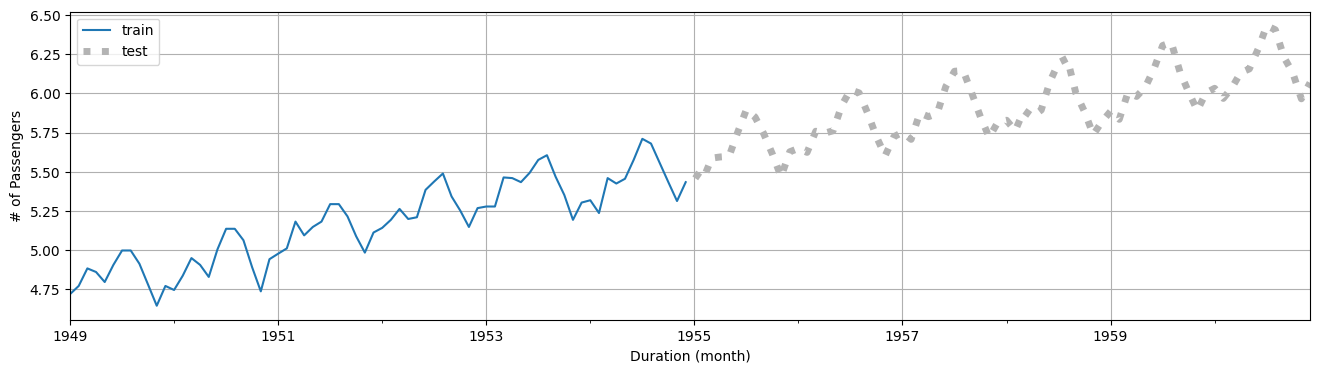

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
# split data into train and test
from sklearn.model_selection import train_test_split
train_size = 0.5
train, test = train_test_split(data_log, train_size=train_size, shuffle=False)

# plot train and test data
ax1 = train.plot(label='train', figsize=(16,4))
test.plot(label='test',
            color="0.7",
            linestyle='dotted',
            linewidth="5.0",
            ax=ax1)
plt.xlabel('Duration (month)')
plt.ylabel('# of Passengers')
ax1.legend(['train', 'test'])
plt.grid(True)
plt.show()

## <font color="SeaGreen">ARMAでのチューニング例</font>
- ### チューニングなしのパターン
ARMAモデルでは、order=(p, d, q) の d を 0（差分を取らない）に設定します。<br>
まずは、ARMAモデルのパラメータチューニングを行わずに適当なpとqの組み合わせ order=(5, 0, 5) でモデルを構築し予測してみます。

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 161.224
MAPE: 0.329
MAE: 136.328
MSE: 25993.086


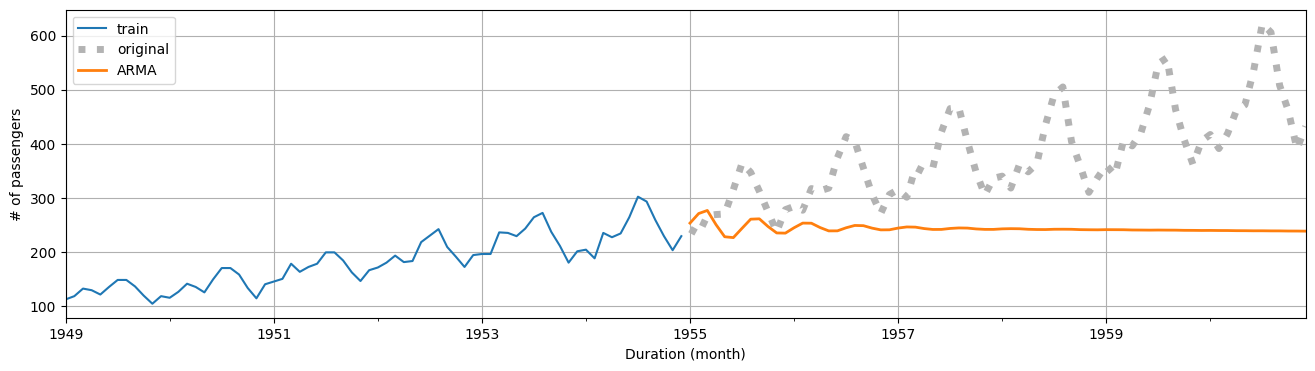

In [4]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# fit ARMA model (p=5, d=0, q=5)
arma = ARIMA(train, order=(5, 0, 5)).fit()

# forecasting window
st = test.index.to_timestamp()[0]
ed = test.index.to_timestamp()[-1]

# forecasting st to ed
arma_pred = arma.predict(start=st, end=ed)

# RMSE
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(arma_pred)))
print(f"RMSE: {round(rmse, 3)}")

# MAPE
mape = mean_absolute_percentage_error(np.exp(test), np.exp(arma_pred))
print(f"MAPE: {round(mape, 3)}")

# MAE
mae = mean_absolute_error(np.exp(test), np.exp(arma_pred))
print(f"MAE: {round(mae, 3)}")

# MSE
mse = mean_squared_error(np.exp(test), np.exp(arma_pred))
print(f"MSE: {round(mse, 3)}")

# plot figure
ax1 = np.exp(train).plot(figsize=(16, 4))
np.exp(test).plot(color='0.7', linestyle='dotted', linewidth='5.0', ax=ax1)
np.exp(arma_pred).plot(linewidth='2.0', ax=ax1)

plt.legend(['train', 'original', 'ARMA'])
plt.xlabel('Duration (month)')
plt.ylabel('# of passengers')
plt.grid(True)
plt.show()

- ### チューニングありのパターン
ARMAモデルのパラメータチューニングをしてみましょう。<br>
ここでは、AIC値を利用して、最適なpとqの組み合わせを選択してみます。

In [5]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")

# 乱数シードの固定
random.seed(42)
np.random.seed(42)

# パラメータ範囲の設定
p_range = range(0, 11)  # pの候補
q_range = range(0, 11)  # qの候補

# AIC
aic_results = []

# モデルの試行
for p in p_range:
    for q in q_range:
        try:
            # ARIMAモデルのフィッティング (d=0)
            model = ARIMA(train, order=(p, 0, q)).fit()
            # 結果を保存
            aic_results.append((p, q, model.aic))
        except Exception as e:
            # モデルが適合しない場合（収束エラーなど）をスキップ
            aic_results.append((p, q, np.inf))

# 最適な(p, q)の選択
best_model = min(aic_results, key=lambda x: x[2])  # AICが最小の組み合わせを取得
best_p, best_q, best_aic = best_model

# 結果の表示
print("Best Model: ARMA({}, 0, {}) with AIC: {}".format(best_p, best_q, best_aic))

# 全結果の表示
print("\nAll AIC Results:")
for p, q, aic in sorted(aic_results, key=lambda x: x[2]):
    print(f"p={p}, q={q}, AIC={aic}")


Best Model: ARMA(10, 0, 9) with AIC: -155.31307282493816

All AIC Results:
p=10, q=9, AIC=-155.31307282493816
p=8, q=7, AIC=-153.3785395268509
p=10, q=10, AIC=-150.59764494958424
p=9, q=10, AIC=-149.49191556876855
p=9, q=7, AIC=-146.37180875125887
p=10, q=6, AIC=-145.81259514457858
p=9, q=9, AIC=-144.64124528762216
p=10, q=5, AIC=-143.7012247460919
p=10, q=8, AIC=-143.05415827500943
p=5, q=9, AIC=-142.1664743070998
p=9, q=6, AIC=-140.28706720165593
p=6, q=10, AIC=-137.83215195205966
p=6, q=9, AIC=-137.7742479324881
p=8, q=9, AIC=-137.33719959691948
p=8, q=8, AIC=-136.96611951787924
p=9, q=4, AIC=-136.47913091341752
p=9, q=8, AIC=-134.70290195530225
p=9, q=5, AIC=-133.5277217884102
p=5, q=10, AIC=-133.14699716096655
p=10, q=7, AIC=-133.09962425360266
p=1, q=10, AIC=-132.4458156717765
p=3, q=10, AIC=-129.76852536411403
p=3, q=6, AIC=-129.33917249031532
p=6, q=7, AIC=-129.26158400541502
p=10, q=3, AIC=-127.99428011646705
p=7, q=10, AIC=-127.94528882829519
p=9, q=3, AIC=-127.9093409538956


最小のAICは -155.31307282493816、order=(10, 0, 9) となりました。<br>
この値を利用してARMAモデルを構築し予測したいと思います。

RMSE: 136.443
MAPE: 0.279
MAE: 115.147
MSE: 18616.568


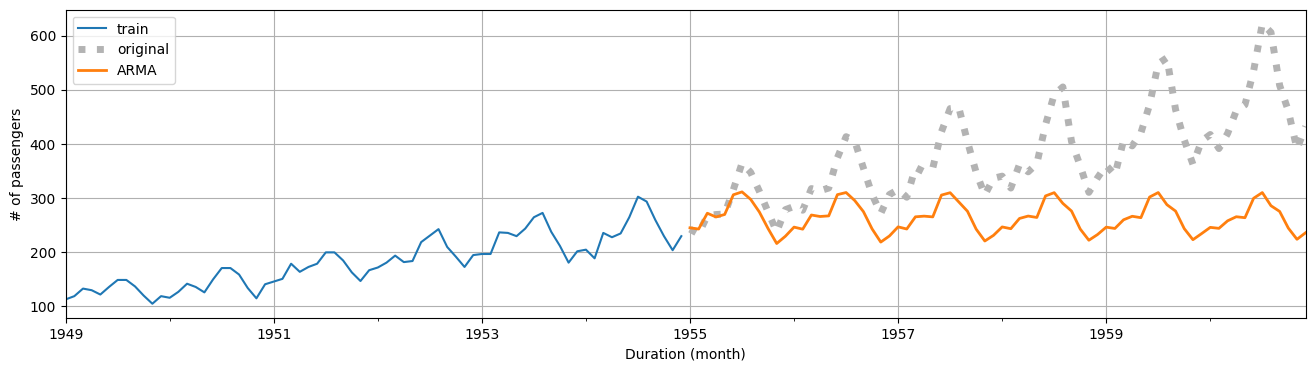

In [6]:
# fit ARMA model (p=10, d=0, q=9)
arma = ARIMA(train, order=(10, 0, 9)).fit()

# forecasting window
st = test.index.to_timestamp()[0]
ed = test.index.to_timestamp()[-1]

# forecasting st to ed
arma_pred = arma.predict(start=st, end=ed)

# RMSE
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(arma_pred)))
print(f"RMSE: {round(rmse, 3)}")

# MAPE
mape = mean_absolute_percentage_error(np.exp(test), np.exp(arma_pred))
print(f"MAPE: {round(mape, 3)}")

# MAE
mae = mean_absolute_error(np.exp(test), np.exp(arma_pred))
print(f"MAE: {round(mae, 3)}")

# MSE
mse = mean_squared_error(np.exp(test), np.exp(arma_pred))
print(f"MSE: {round(mse, 3)}")

# plot figure
ax1 = np.exp(train).plot(figsize=(16, 4))
np.exp(test).plot(color='0.7', linestyle='dotted', linewidth='5.0', ax=ax1)
np.exp(arma_pred).plot(linewidth='2.0', ax=ax1)

plt.legend(['train', 'original', 'ARMA'])
plt.xlabel('Duration (month)')
plt.ylabel('# of passengers')
plt.grid(True)
plt.show()


チューニング前→チューニング後の評価指標を用いた結果を確認してみましょう。<br>
RMSE：161.224 → 136.443<br>
MAPE：0.329 → 0.279<br>
MAE：136.328 → 115.147<br>
MSE：259993.086 → 18616.568
全ての評価指標の値が小さくなり、モデルの性能が改善されたことが分かります。

## <font color="SeaGreen">ARIMAでのチューニング例</font>
- ### チューニングなしのパターン
まずは、ARIMAモデルのパラメータチューニングを行わずに適当なpとdとqの組み合わせ order=(11, 1, 8) でモデルを構築し予測してみます。

RMSE: 135.583
MAPE: 0.283
MAE: 115.825
MSE: 18382.781


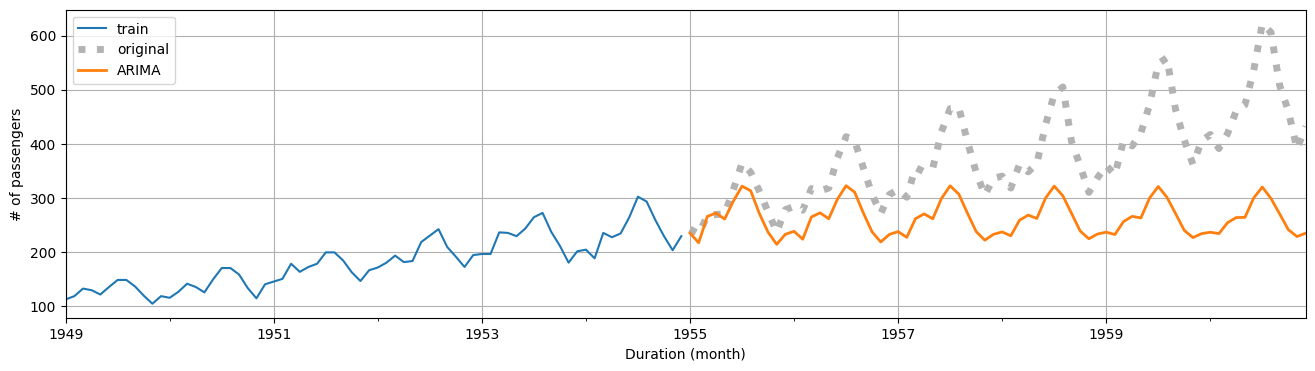

In [7]:
# fit ARIMA model (p=11, d=1, q=8)
arima= ARIMA(train, order=(11, 1, 8)).fit()

# forecasting window
st = test.index.to_timestamp()[0]
ed = test.index.to_timestamp()[-1]

# forecasting
arima_pred = arima.predict(st, ed)

# RMSE
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(arima_pred)))
print(f"RMSE: {round(rmse, 3)}")

# MAPE
mape = mean_absolute_percentage_error(np.exp(test), np.exp(arima_pred))
print(f"MAPE: {round(mape, 3)}")

# MAE
mae = mean_absolute_error(np.exp(test), np.exp(arima_pred))
print(f"MAE: {round(mae, 3)}")

# MSE
mse = mean_squared_error(np.exp(test), np.exp(arima_pred))
print(f"MSE: {round(mse, 3)}")

# plot figure
ax1 = np.exp(train).plot(figsize=(16,4))
np.exp(test).plot(color='0.7', linestyle='dotted', linewidth='5.0', ax=ax1)
np.exp(arima_pred).plot(linewidth='2.0', ax=ax1)

plt.legend(['train', 'original', 'ARIMA'])
plt.xlabel('Duration (month)')
plt.ylabel('# of passengers')
plt.grid(True)
plt.show()

- ### チューニングありのパターン
ARIMAモデルのパラメータチューニングをしてみましょう。<br>
ここでは、AIC値を利用して、最適なpとdとqの組み合わせを選択してみます。

In [8]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import random

# 乱数シードの固定
random.seed(42)
np.random.seed(42)

# パラメータ範囲の設定
p_range = range(0, 13)  # pの候補
d_range = range(0, 3)   # dの候補 (通常は0〜2で十分)
q_range = range(0, 11)  # qの候補

# AIC
aic_results = []

# モデルの試行
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                # ARIMAモデルのフィッティング
                model = ARIMA(train, order=(p, d, q)).fit()
                # 結果を保存
                aic_results.append((p, d, q, model.aic))
            except Exception as e:
                # モデルが適合しない場合（収束エラーなど）をスキップ
                aic_results.append((p, d, q, np.inf))

# 最適な(p, d, q)の選択
best_model = min(aic_results, key=lambda x: x[3])  # AICが最小の組み合わせを取得
best_p, best_d, best_q, best_aic = best_model

# 結果の表示
print("Best Model: ARIMA({}, {}, {}) with AIC: {}".format(best_p, best_d, best_q, best_aic))

# 全結果の表示
print("\nAll AIC Results:")
for p, d, q, aic in sorted(aic_results, key=lambda x: x[3]):
    print(f"p={p}, d={d}, q={q}, AIC={aic}")


Best Model: ARIMA(12, 1, 1) with AIC: -184.107959383767

All AIC Results:
p=12, d=1, q=1, AIC=-184.107959383767
p=12, d=1, q=3, AIC=-182.5910213983203
p=12, d=1, q=2, AIC=-181.93045085626753
p=12, d=1, q=4, AIC=-180.06280699249456
p=12, d=1, q=0, AIC=-179.03551682233334
p=12, d=1, q=5, AIC=-178.98659256325877
p=11, d=2, q=1, AIC=-178.1272223715891
p=12, d=2, q=0, AIC=-178.1010248282729
p=11, d=2, q=3, AIC=-177.28060582722316
p=12, d=1, q=6, AIC=-177.2428956995203
p=12, d=1, q=7, AIC=-176.97559647858435
p=11, d=2, q=4, AIC=-176.46896304687561
p=11, d=2, q=2, AIC=-176.25540235918504
p=10, d=1, q=10, AIC=-175.27854060193843
p=12, d=2, q=1, AIC=-175.18486426604437
p=12, d=1, q=8, AIC=-174.99781263860342
p=12, d=1, q=9, AIC=-174.6923442100406
p=12, d=1, q=10, AIC=-173.7309807033959
p=12, d=2, q=3, AIC=-173.4971878337864
p=12, d=2, q=2, AIC=-173.28515028468192
p=11, d=2, q=5, AIC=-172.89883531911929
p=12, d=2, q=4, AIC=-172.83243186795025
p=11, d=1, q=8, AIC=-172.62130825481327
p=11, d=2, q=

最小のAICは -184.107959383767、order=(12, 1, 1) となりました。<br>
この値を利用してARIMAモデルを構築し予測したいと思います。

RMSE: 109.267
MAPE: 0.225
MAE: 92.287
MSE: 11939.246


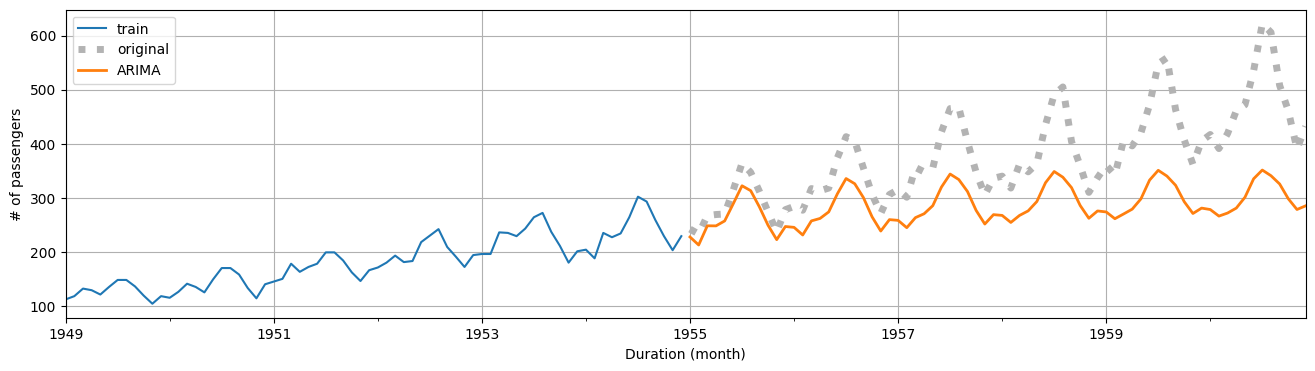

In [9]:
# fit ARIMA model (p=12, d=1, q=1)
arima= ARIMA(train, order=(12, 1, 1)).fit()

# forecasting window
st = test.index.to_timestamp()[0]
ed = test.index.to_timestamp()[-1]

# forecasting
arima_pred = arima.predict(st, ed)

# RMSE
rmse = np.sqrt(mean_squared_error(np.exp(test), np.exp(arima_pred)))
print(f"RMSE: {round(rmse, 3)}")

# MAPE
mape = mean_absolute_percentage_error(np.exp(test), np.exp(arima_pred))
print(f"MAPE: {round(mape, 3)}")

# MAE
mae = mean_absolute_error(np.exp(test), np.exp(arima_pred))
print(f"MAE: {round(mae, 3)}")

# MSE
mse = mean_squared_error(np.exp(test), np.exp(arima_pred))
print(f"MSE: {round(mse, 3)}")

# plot figure
ax1 = np.exp(train).plot(figsize=(16,4))
np.exp(test).plot(color='0.7', linestyle='dotted', linewidth='5.0', ax=ax1)
np.exp(arima_pred).plot(linewidth='2.0', ax=ax1)

plt.legend(['train', 'original', 'ARIMA'])
plt.xlabel('Duration (month)')
plt.ylabel('# of passengers')
plt.grid(True)
plt.show()

チューニング前→チューニング後の評価指標を用いた結果を確認してみましょう。<br>
RMSE：135.583 → 109.267<br>
MAPE：0.283 → 0.225<br>
MAE：115.825 → 92.287<br>
MSE：18382.781 → 11939.246
全ての評価指標の値が小さくなり、モデルの性能が改善されたことが分かります。

# <font color="DarkOrange">5. まとめ</font>
本章では、実際のデータを使いながら、モデルの評価指標やチューニングの手法について解説しました。<br>
それぞれの評価指標の特性を理解し、メリットやデメリットを考慮しながら、適切なモデル選択や調整を行うことが重要です。また、過学習を防ぎ、汎化性能の高いモデルを構築するために、データの分割やクロスバリデーションなどの手法を活用してください。これらの手法を組み合わせて、実践的な時系列解析を進めていきましょう。


